<h1 style="text-align: center; font-size: 54px;">Blending Aggregation with Pandas</h1>


## https://github.com/terakilobyte/euroscipy.git

In [53]:
 mkdir testdata
 mongod --dbpath=testdata
 mongorestore dump --gzip
 mongo
   > show dbs
 Download Compass: https://www.mongodb.com/products/compass

from utils.workshop import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

The goal of this tutorial is to teach/intrigue/inspire better analytics by blending MongoDB's Aggregation Framework with existing analysis tools to achieve desired results faster and more efficiently.

<h2 style="font-size: 36px; text-align: center;">The Problem</h1>

<img src="assets/everything.jpg" style="margin: 20px auto; max-width: 800px; max-height: 800px;"/>

Without Aggregation on the database layer, any question we ask is potentially inefficient. Doing everything with the client results in the transfer of all data, resulting in increased bandwidth consumption and greater memory and processor usage.

## Finding things

First, let's create some data to play with.

In [54]:
very_important_data = [{"value": x} for x in range(100)]

In [55]:
df = pd.DataFrame.from_dict(very_important_data)

In [56]:
df.head()

,value
0,0
1,1
2,2
3,3
4,4


Now, let's put the same data in MongoDB.

In [57]:
from pymongo import MongoClient

client = MongoClient()
mdbw = client.mdbw
tutorial = mdbw.tutorial
student_course = mdbw.student_course
my_coll = mdbw.my_coll

In [58]:
tutorial.drop()
tutorial.insert_many(very_important_data)

Let's find all the values that are evenly divisible by 2.

In [59]:
only_evens = df.loc[df['value'] % 2 == 0]
only_evens.count()

value    50
dtype: int64

In [60]:
only_evens.head()

,value
0,0
2,2
4,4
6,6
8,8


Now in MongoDB.

The "old" way

In [61]:
m_evens = {
    "$addFields": {
        "is_even": {"$eq": [{ "$mod": [ "$value", 2 ]}, 0]}
    }
}
m_match = {
    "$match": {
        "is_even": True
    }
}
m_results1 = list(tutorial.aggregate([m_evens, m_match]))

The "new" way

In [62]:
m_evens = {
    "$match": {
        "$expr": {"$eq": [{"$mod": ["$value", 2]}, 0]}
    }
}
m_results2 = list(tutorial.aggregate([m_evens]))

In [63]:
m_df1 = pd.DataFrame.from_dict(m_results1)
m_df2 = pd.DataFrame.from_dict(m_results2)

In [64]:
m_df1.count()

_id        50
is_even    50
value      50
dtype: int64

In [65]:
m_df2.count()

_id      50
value    50
dtype: int64

In [66]:
m_df1.head()

,_id,is_even,value
0,5b85137d4a68c332f4dbdf75,True,0
1,5b85137d4a68c332f4dbdf77,True,2
2,5b85137d4a68c332f4dbdf79,True,4
3,5b85137d4a68c332f4dbdf7b,True,6
4,5b85137d4a68c332f4dbdf7d,True,8


In [67]:
m_df2.head()

,_id,value
0,5b85137d4a68c332f4dbdf75,0
1,5b85137d4a68c332f4dbdf77,2
2,5b85137d4a68c332f4dbdf79,4
3,5b85137d4a68c332f4dbdf7b,6
4,5b85137d4a68c332f4dbdf7d,8


We can quickly get rid of the `_id` field that MongoDB automatically created, as well as the `is_even` field we created as a placeholder.

In [68]:
m_df1.drop(labels=["_id", "is_even"], axis=1, inplace=True)
m_df2.drop(labels=["_id"], axis=1, inplace=True)

In [69]:
m_df1.head()

,value
0,0
1,2
2,4
3,6
4,8


In [70]:
m_df2.head()

,value
0,0
1,2
2,4
3,6
4,8


## Let's break down what we just didn't do.

We didn't use a `$match` stage to find documents where the **value** was even.

MongoDB's Aggregation Framework is a data pipeline. Documents aren't fetched, instead they flow through the pipeline and each stage transforms the documents in some way. So, all 100 documents entered the `$addFields` stage in the first example. They then entered the `$match` stage, and were filtered out.

![agg_factor](assets/agg_factory.gif)

## $match

`$match` in aggregation is akin to the `df.loc` method in Pandas, `find` in MQL, and `SELECT` in SQL.
Unlike the rest of the stages in the Aggregation Framework, `$match` uses the "standard" MQL operators.

In the second version, we used the **$expr** expression that was added in MongoDB 3.6. It allows us to "break free" from standard MQL and use aggregation expressions.

## Expressions

The next area we'll cover is expressions. If stages like `$match`, `$project`, and `$group` are the assembly stations of an aggregation pipeline, expressions are the individual tools at each station.

Expressions are functions. With them we can add, multiply, get square roots, join sets, and much, much more. Here are functionally identical examples of a function called add.

- Python

```python
    def add(a, b):
        return a + b
```

- Aggregation Syntax

```js
    { "$add": [ "$a", "$b" ] }
```

Here's another example for a function called `floor`, which floors the input to the next lowest integer value.

Python:

```python
    def floor(a):
        return int(a)
```

Aggregation:

```json
    { "$floor": "$a" }
```

And just like functions, expressions can be composed together. Currently there is no round function in the Aggregation Framework, but we can make it by composing `$floor` and `$add` together.

```json
    { "$floor": { "$add": [ "$a", 0.5 ] } }
```

Let's take a closer look at our custom `round` expression to get a feel for aggregation semantics.

    { "$floor": { "$add": [ "$a", 0.5 ] } }

    { "$floor": { "$add": [ "$a", 0.5 ] } }
    ^           ^                       ^ ^
    
Unless an expression is entirely self contained, it is surrounded by curly brackets. These delimit the scope of the expression.

Expressions are evaluated from the inside out. So, the `$add` expression is evaluated before the `$floor` expression.

    { "$floor": { "$add": [ "$a", 0.5 ] } }
                          ^           ^

As a general rule, expressions that take multiple arguments accept them in an array. Some expressions only accept 1 or 2 arguments, like `$subtract`, while others are variadic (number of arguments isn't fixed), like `$add`.

    { "$floor": { "$add": [ "$a", 0.5 ] } }
                              ^
                              
Lastly, let's cover field path expressions. Field path expressions are self contained, hence there's no need to surround them with curly braces when composing them with other expressions or using them to supply an argument to an expression.

Field path expressions refer to a value in the current document. In our custom `round` expression, `"$a"` refers to the value in the current document that has a key of **a**. We saw this earlier when we referenced the value of **value** with `$value`.

## Expression "Categories"

There are many built-in expressions in the Aggregation Framework that fall into several categories.

![expression categories](assets/expression-categories.png)

## `$addFields`

Earlier in the first version of the aggregation, we used a stage called `$addFields`. `$addFields` allows us to temporarily derive and store values in documents as they pass through the data pipeline.

`$addFields` - and `$project`, the sibling for `$addFields` - should be considered a main transformative stage, akin to `map` in many programming languages.

## Exercise - Get the number of submissions per day

In this exercise, you'll have to use `$match` and `$addFields` to get the number of submissions that fell on a Tuesday, the end/beginning of an academic week on MongoDB University. This information is in the `student_course` collection.

The final count stage is provided for you.

In [ ]:
mark_day_of_week = {
    "$addFields": {
        "dayofweek": <your code here>
    }
}

# remember that Sunday is 1, Saturday is 7
on_tuesday = {
    "$match": {
        "dayofweek": <your code here>
    }
}

# don't change this count stage
count = {
    "$count": "submissions"
}

m_print(student_course.aggregate([mark_day_of_week, on_tuesday, count]))

### Solution

In [ ]:
%load fragments/euroscipy_tuesdays.py

## `$group`

`$group` has the following form
```
"$group": {
    "_id": <expression>,
    "fieldN": { <accumulatorN>: <expressionN> },
    ...
}
```

**_id** is any expression or composition of expressions to match similar documents together on.

**fieldN** is an optional field, and as hinted at by the postfixed "N", can be any number of fields. 

Each field specified accepts an accumulator and expression to accumlate.

When we say that the **_id** field in `$group` can be any expression or composition of expressions to group similar documents together with, we really mean it.

Let's explore `$group` in isolation to get a sense for how powerful it is, as well as how accumulator expressions work and some very common patterns.

First, we'll insert 100 documents into a test collection. They'll be of the shape
```
{
    "_id": <assigned by mongod>,
    "value": 0..100
}
```

In [ ]:
my_coll.drop()
my_coll.insert_many([{"value": n} for n in range(100)])
print(my_coll.count_documents({}))
m_print(my_coll.find_one())

Alright, we have 100 documents inserted into our collection, with values ranging from 0 to 99.

First, let's `$group` similar documents together. We're also going to use a very common accumulator expression to count how many documents were grouped together, called `$sum`.

In [ ]:
grouping_by_odd_or_even = {
    "$group": {
        "_id": {
            "$cond": [ 
                { "$eq": [{"$mod": [ "$value", 2 ] }, 0] }, 
                "even", 
                "odd" 
            ]
        },
        "count": { "$sum": 1 }
    }
}
m_print(my_coll.aggregate([grouping_by_odd_or_even]))

OK let's break this down.

Within the **_id** argument, we specified one of the _control flow_ expressions, `$cond`. 

It can be read as

**if** `{ "$eq": [{"$mod": [ "$value", 2 ] }, 0] },`

**then** `"even",`

**else** `"odd",`

The next portion is the accumulator expression block. We specified a field called `count`, but it could have been any name. Within, we use the accumulator expression `$sum`.

`"count": { "$sum": 1 }` can be thought of as the instruction "for every document that matches, **sum** 1 with the current value of **count**. So the first time it matched, it summed 1 and 0, then 1 and 1, then 1 and 2, and so on.

We would expect that both **count** fields in the output documents were 50, as there are 50 even and 50 odd numbers in the interval **[0, 99]**

Following is an almost identical example, however it won't use the `$cond` expression and will use the name **documents_matched** instead of count. What do you expect the output to be?

In [ ]:
grouping_by_odd_or_even = {
    "$group": {
        "_id": { "$eq": [{"$mod": [ "$value", 2 ] }, 0] }, 
        "documents_matched": { "$sum": 1 }
    }
}
m_print(my_coll.aggregate([grouping_by_odd_or_even]))

Because we didn't specify the `$cond`, we got the raw output from the expression, which is a boolean true/false. We can see that the **documents_matched** key is what we expected, 50.

Alright, let's have a little bit of fun.

We're going to solve a variation of **FizzBuzz** with aggregation.

If you aren't familiar, FizzBuzz is a programming problem where you take the interval [0, 99] or [1, 100] and do the following:
- If the number if divisible by 3, output "Fizz"
- If the number is divisible by 5, output "Buzz"
- If the number is divisible by 15, output "FizzBuzz"
- If the number doesn't meet one of the above criteria, output the number itself

We'll group on this criteria instead, and use an accumulator expression called `$push` to push values into an array.

To do this, we're going to use a `$switch` expression. We could just nest `$cond` expressions but the syntax starts to get a bit unweildy.

![haduken_code](assets/haduken_code.jpg)

In [ ]:
fizz_buzz = {
    "$group": {
        "_id": {
            "$switch": {
                "branches": [
                    { "case": { "$eq": [{"$mod": [ "$value", 15 ] }, 0] }, "then": "FizzBuzz" },
                    { "case": { "$eq": [{"$mod": [ "$value", 5 ] }, 0] }, "then": "Buzz" },
                    { "case": { "$eq": [{"$mod": [ "$value", 3 ] }, 0] }, "then": "Fizz" }
                ],
                "default": "plain"
            }
        },
        "matching_nums": { "$push": "$value"}
    }
}
m_print(my_coll.aggregate([fizz_buzz]))

Alright, we see that documents where the value was divisible by 15 were matched and the **_id** resulted in "FizzBuzz", and the individual values were pushed into a field called **matching_nums**.

Same for "Fizz" and "Buzz", and because we need a common value to match other values together with, we chose to use "plain" if no branches in our `$switch` matched.

We can also `$group` all input documents together. To do so, we specify an expression or value that won't be enountered in any documents. By convention, we tend to use the value **0**.

Let's look at an example. We'll `$group` all of the documents together, and use some mathematical accumulator expressions to find the `$max`, `$min`, `$avg`, `$sum`, and `$stdDevPop`.

In [ ]:
the_stats = {
    "$group": {
        "_id": 0,
        "max": { "$max": "$value" },
        "min": { "$min": "$value" },
        "avg": { "$avg": "$value" },
        "sum": { "$sum": "$value" },
        "sd": { "$stdDevPop": "$value" }
    }
}
m_print(my_coll.aggregate([the_stats]))

## Exercise - Group problem submissions by day of week and output count.

For this exercise, group problem submissions together based on the day of the week they were submitted and output a count.

In [ ]:
submissions = {
    "$group": {
    }
}
m_print(student_course.aggregate([submissions]))

### Solution

In [ ]:
%load fragments/euroscipy_first_group.py

Let's sort them in descending order, so they are greatest to least.

In [ ]:
# %load fragments/euroscipy_first_group.py
submissions = {
    "$group": {
        "_id": {
            "$dayOfWeek": "$updated_at"
        },
        "count": { "$sum": 1 }
    }
}
m_print(student_course.aggregate([submissions]))


In [ ]:
sorting = {
    "$sort": { "count": -1 }
}
m_print(student_course.aggregate([submissions, sorting]))

## Introducing ``$sortByCount``

`$sortByCount` does the same thing as a `$group` followed by a `$sort`.

In [ ]:
group_and_sort = {
    "$sortByCount": {"$dayOfWeek": "$updated_at"}
}
m_print(student_course.aggregate([group_and_sort]))

## `$lookup`

`$lookup` has two forms. In this workshop, we'll focus on the new form. It looks like this

```
"$lookup": {
    "from": <string>,
    "let": <expressions>,
    "pipeline: [<aggregation pipeline>],
    "as": <string>
}
```

This form of `$lookup` was introduced in MongoDB 3.6 and is **very** powerful. Here's an example of this form being used in one of the pipelines that was used to prepare the data for this workshop!

```
...
    {
        "$lookup": {
            "from": "answers_etl",
            "let": {"source": "$submissions.problem_id"},
            "pipeline": [
                {
                    "$match": {
                        "$expr": {"$eq": ["$problem_id", "$$source"]}
                    }
                },
                {
                    "$project": {
                        "_id": 0,
                        "answer": 1
                    }
                }
            ],
            "as": "answer"
        }
    },
...
```

Let's break this down.

- First, we specify the `from` collection as **answers_etl**, a prepared collection that has problem answers.
- In `let`, we bind the value of the current document's **$submission.problem_id** to the name **source**. We'll reference this name within the pipeline.
- In `pipeline`, we define an aggregation pipeline that executes in the context of the collection that we specified in `from`.
- This pipeline matches where the **problem_id** in documents in the **answer_etl** collection match the **$$source** value, the value we bound in `let`. It then projects away the **_id** and keeps the **answer** value.
- Lastly, we return the results and store them in a field called **answer**.

## Exercise - Lookup

Let's run through a quick exercise. We'd like to use a `$lookup` to get a list of students who have taken the **most** MongoDB Certified Developer/DBA exams.

In [ ]:
exams_by_student = [
    {
        "$project": {
            "_id": 0,
            "user_id": 1
        }
    },
    {
        "$lookup": {
            <your code here>
        }
    },
    {
        "$match": {
            "exams": { "$ne": [] }
        }
    },
    {
        "$addFields": {
            "exams": { "$arrayElemAt": ["$exams.exams", 0]}
        }
    },
    {
        "$sort": {"exams": -1}
    }
]
m_print(student_course.aggregate(exams_by_student))

### Solution

In [ ]:
%load fragments/euroscipy_lookup.py

## Let's do some analysis.

Let's find out when students on MongoDB University are **most** active in submitting their homework.

In MongoDB Aggregation, using `$facet`

## `$facet`

`$facet` is a very powerful stage and perhaps one of the most misunderstood. `$facet` allows us to execute multiple pipelines within a single aggregation.

This is very useful if we want to perform more than one transformation of our data but each transformation alone would prevent the other. It's also useful when we want to get multiple different metrics. For example, an ecommerce site might use facet to return results based on review rating and price. This takes a lot of the heavy lifting off of the UI and allows the UI to focus on what it should, giving end users a great experience.

In [46]:
def generate_sub_agg(dayOfWeek):
    return [
        {
            "$match": {
                "$expr": { "$eq": [ {"$dayOfWeek": "$updated_at" }, dayOfWeek] }
            }
        },
        {
            "$bucket": {
                "groupBy": { "$hour": "$updated_at" },
                "boundaries": [x for x in range(25)],
                "output": {
                    "count": { "$sum": 1 }
                }
            }
        }
    ]

In [47]:
pipeline = [
    {
        "$facet": {
            "sunday": generate_sub_agg(1),
            "monday": generate_sub_agg(2),
            "tuesday": generate_sub_agg(3),
            "wednesday": generate_sub_agg(4),
            "thursday": generate_sub_agg(5),
            "friday": generate_sub_agg(6),
            "saturday": generate_sub_agg(7)
        }
    }
]

In [48]:
by_hour_breakdown = list(student_course.aggregate(pipeline))[0]

In [49]:
data =[{"day": k, "stats": pd.DataFrame(list(map(lambda x: {"hour": x["_id"], "count": x["count"]}, v)))} for (k, v) in by_hour_breakdown.items()]
m_df = pd.DataFrame(data)

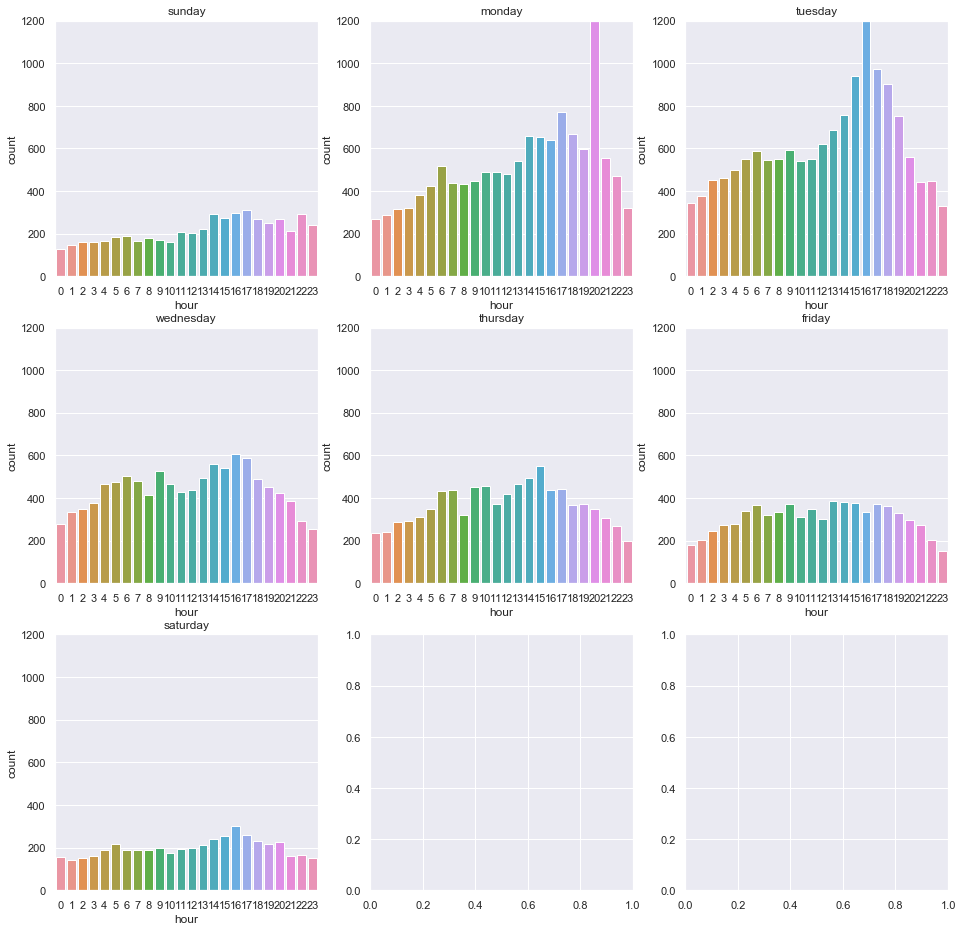

In [50]:
fig, axs = plt.subplots(ncols=3, nrows=3,figsize=(16, 16))
days = m_df['day'].tolist()
x = 0
for day in m_df['day']:
    bp = sns.barplot(
        x="hour", 
        y="count", 
        data=m_df['stats'][days.index(day)], 
        ax=axs[x//3, x%3]
    ).set_title(day)
    axes = bp.axes
    axes.set_ylim(0,1200)
    x+=1